# Scenario: A Principal’s Academy to Improve College-Going and College-Readiness

Superintendent Jeff Wiggins joined the School District of San Metropolis (SDSM) in February 2012. SDSM is located in a moderately-sized city in the South East and enrolls approximately 38,000 students in 73 schools (40 elementary schools, 20 middle schools, and 13 high schools). Though the district demonstrates success with on-time high school graduation rates, a good percentage of graduates do not enroll in college. 

Wiggins is keen on improving college readiness for all youths and increasing the rate of college enrollment among graduates. The community is equally passionate about improving its students’ postsecondary success. For many of these students, college is not seen as a viable option. Wiggins believes that the district can improve college readiness among all SDSM students by first identifying high schools to serve as **models of success** and then learning from these models about best practices for producing **college ready** students who enroll and persist in college. Therefore, Wiggins has asked you to examine available data and report out on _which school_ you would recommend as the first site.   

He would like to receive a short memo that outlines your selection and justification, accompanied by a visual display that he can share with additional stakeholders to tell the story of why your selection was chosen as the first site. He leaves it to you to decide on the appropriate selection criteria and mentions that it seems important to include the high school’s current college outcomes in the decision process.


# 1. Preparing data in notebook
### 1.1. Libraries

In [1]:
import pandas as pd
import numpy as np
import re

from matplotlib import*
import matplotlib.pyplot as plt
from matplotlib.cm import register_cmap

import seaborn as sns

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, FactorRange
from bokeh.io import show, output_file
from bokeh.models.tickers import FixedTicker
from bokeh.models import Arrow, OpenHead, NormalHead, VeeHead

from pprint import pprint

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy import stats
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA

### 1.2. Functions

In [2]:
# This function takes a string and process it as follow:
# 1. Takes out all the non-alphanumeric characters
# 2. Converts the spaces -of any length- into underscores
# 3. Lowercase alphabets
# Note: NANs converted into zero-length string to avoid error

def unitext(text_in):
    if pd.isnull(text_in) == False:
        text_in == text_in
    else:
        text_in = ' '
    
    text_01 = re.sub('[^a-zA-Z0-9\s]','',text_in) #Takes out all the non-alphanumeric characters
    text_02 = re.sub('\s+','_',text_01) # Converts the spaces -of any length- into underscores
    text_03 = str.lower(text_02)
    text_04 = re.sub('\_$','',text_03) # Trims ending space characters
    text_05 = re.sub('^\_','',text_04) # Trims begining space characters
    return text_05

In [3]:
# For labeling purpose. Create a list of PCx or Principal Component x
def pc(num, lng):
    if lng == 0:
        prefix = 'PC'
    else:
        prefix = 'Principal Component '
    pc_list = []
    for i in np.arange(1, num+1):
        pric = prefix+str(i)
        pc_list.append(pric)
    return pc_list

In [38]:
# Expected Proportion of the kth Largest Piece
# Adobted from https://blogs.sas.com/content/iml/2017/08/02/retain-principal-components.html

def exprop(n):
    ex_list = []
    for i in np.arange(1,n+1):
        tempsum = 0
        for j in np.arange(i, n+1):
            tempsum = tempsum + (1/j)
        cor = 100*tempsum/n
        ex_list.append(cor)
    return ex_list

### 1.3. Reading data

In [4]:
df_raw = pd.read_excel('metropolis_dataset.xlsx')

### *Data quality note:*
There are missing data. 

Let's call columns with <1000 missing data as 'rare missing' and otherwise 'frequent missing'.

Coincidence or otherwise, all the rare missings are boolean values.

In [5]:
# Counting missing data
df_raw.isnull().sum()

chrt_grad                        0
hs_name1                         0
s_lasid                          0
s_male                           1
s_frpl                         200
s_lep                            0
s_sped                           0
std_math_8                    2609
std_read_8                    2622
s_satv                        3517
s_satm                        3517
s_satw                        9062
diploma                        139
diploma_ontime                  12
enrl_fall_after_hsgrad_any       2
enrl_fall_after_hsgrad_4yr       2
enrl_fall_after_hsgrad_2yr       2
days_within2yrs_hsgrad_any    3969
days_within2yrs_hsgrad_4yr    7106
days_within2yrs_hsgrad_2yr    8268
counselor_id                   303
dtype: int64

### **The following approach is picked to fill the missing data:**

1. For the rare missing (boolean) data, they will be replaced by a random value.
2. For the frequent missing data, they will be replaced by the median value of the school the student belongs to (so the school average will not significantly change).
3. In case of ```counselor_id``` it will be assumed *unknown*, namely the student had not access to counselor

### 1.4. Cleaning data

In [6]:
# This line will replace the missing values in boolean variable with a random pick between 0 and 1.
df_raw[['s_male','diploma_ontime','s_frpl','diploma','enrl_fall_after_hsgrad_any','enrl_fall_after_hsgrad_2yr','enrl_fall_after_hsgrad_4yr']]=df_raw[['s_male','diploma_ontime','s_frpl','diploma','enrl_fall_after_hsgrad_any','enrl_fall_after_hsgrad_2yr','enrl_fall_after_hsgrad_4yr']].fillna(value=np.random.choice([0,1]))

In [7]:
# The first FOR loop reads all the frequent missing columns, 
# the second FOR loop calculate median for each school and replace the null values for that school.
for i in ['std_math_8','std_read_8','s_satv','s_satm','s_satw','days_within2yrs_hsgrad_any','days_within2yrs_hsgrad_4yr','days_within2yrs_hsgrad_2yr']:
    for j in df_raw.hs_name1.unique().tolist():
        medval = df_raw[df_raw.hs_name1 == j][i].median()
        df_raw.loc[df_raw.hs_name1 == j ,i] = df_raw.loc[df_raw.hs_name1 == j ,i].fillna(value=medval)        

In [8]:
# Null counseler_id will be replaced by 0

df_raw[['counselor_id']]=df_raw[['counselor_id']].fillna(0)

# AT THIS STAGE, GO BACK TO "Counting missing data" AND RERUN THE LINE TO VERIFY NO MISSING DATA IS LEFT.

In [9]:
# There are also duplicated rows that should be removed.
df_raw[df_raw.duplicated(keep=False) == True]

,chrt_grad,hs_name1,s_lasid,s_male,s_frpl,s_lep,s_sped,std_math_8,std_read_8,s_satv,...,s_satw,diploma,diploma_ontime,enrl_fall_after_hsgrad_any,enrl_fall_after_hsgrad_4yr,enrl_fall_after_hsgrad_2yr,days_within2yrs_hsgrad_any,days_within2yrs_hsgrad_4yr,days_within2yrs_hsgrad_2yr,counselor_id
9,2013,Hope High School,176,1.0,0.0,0,0,1.14,1.27,610.0,...,540.0,1.0,1.0,1.0,1.0,0.0,490.0,490.0,118.0,14.0
10,2013,Hope High School,176,1.0,0.0,0,0,1.14,1.27,610.0,...,540.0,1.0,1.0,1.0,1.0,0.0,490.0,490.0,118.0,14.0
12,2013,Hope High School,205,0.0,0.0,0,0,0.55,0.49,550.0,...,540.0,1.0,1.0,0.0,0.0,0.0,0.0,459.0,118.0,17.0
13,2013,Hope High School,205,0.0,0.0,0,0,0.55,0.49,550.0,...,540.0,1.0,1.0,0.0,0.0,0.0,0.0,459.0,118.0,17.0
42,2013,Hope High School,614,1.0,0.0,1,0,-0.21,0.50,440.0,...,540.0,1.0,1.0,1.0,0.0,1.0,249.0,459.0,249.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11552,2015,Washington High School,12871,1.0,0.0,0,0,0.94,0.62,480.0,...,490.0,1.0,1.0,0.0,0.0,0.0,396.0,456.0,129.0,132.0
11678,2015,Washington High School,14608,0.0,1.0,0,0,-1.16,-0.75,370.0,...,360.0,1.0,1.0,1.0,1.0,0.0,396.0,456.0,129.0,136.0
11679,2015,Washington High School,14608,0.0,1.0,0,0,-1.16,-0.75,370.0,...,360.0,1.0,1.0,1.0,1.0,0.0,396.0,456.0,129.0,136.0
11692,2015,Washington High School,14830,0.0,0.0,0,0,1.10,1.03,490.0,...,440.0,1.0,1.0,1.0,1.0,0.0,396.0,456.0,129.0,136.0


In [10]:
# Remove duplicated records.
df_nonull = df_raw.drop_duplicates()
df_nonull.reset_index(drop = True)

,chrt_grad,hs_name1,s_lasid,s_male,s_frpl,s_lep,s_sped,std_math_8,std_read_8,s_satv,...,s_satw,diploma,diploma_ontime,enrl_fall_after_hsgrad_any,enrl_fall_after_hsgrad_4yr,enrl_fall_after_hsgrad_2yr,days_within2yrs_hsgrad_any,days_within2yrs_hsgrad_4yr,days_within2yrs_hsgrad_2yr,counselor_id
0,2013,Hope High School,9,0.0,0.0,0,1,-0.65,0.46,550.0,...,540.0,1.0,1.0,1.0,0.0,1.0,240.0,459.0,240.0,17.0
1,2013,Hope High School,11,1.0,0.0,0,0,-0.85,-0.92,540.0,...,540.0,1.0,1.0,1.0,1.0,0.0,506.0,264.0,242.0,15.0
2,2013,Hope High School,14,1.0,0.0,0,0,0.68,-0.40,490.0,...,540.0,1.0,1.0,1.0,1.0,0.0,515.0,515.0,118.0,17.0
3,2013,Hope High School,26,0.0,0.0,0,0,0.28,0.77,610.0,...,540.0,1.0,1.0,1.0,1.0,0.0,529.0,529.0,118.0,12.0
4,2013,Hope High School,36,0.0,0.0,0,0,0.53,0.06,450.0,...,540.0,1.0,1.0,1.0,0.0,1.0,481.0,459.0,481.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11345,2015,Washington High School,14830,0.0,0.0,0,0,1.10,1.03,490.0,...,440.0,1.0,1.0,1.0,1.0,0.0,396.0,456.0,129.0,136.0
11346,2015,Washington High School,14857,1.0,0.0,0,0,2.51,1.72,710.0,...,750.0,1.0,1.0,1.0,1.0,0.0,396.0,456.0,129.0,133.0
11347,2015,Washington High School,14858,1.0,0.0,0,0,2.13,0.91,710.0,...,630.0,1.0,1.0,1.0,1.0,0.0,396.0,456.0,129.0,137.0
11348,2015,Washington High School,14881,1.0,1.0,0,0,0.01,0.09,280.0,...,290.0,1.0,1.0,1.0,0.0,1.0,396.0,456.0,129.0,133.0


In [11]:
# Changing school names into script version for ease of coding
for i in np.arange(df_nonull.shape[0]):
    df_nonull.iloc[i,1] = unitext(df_nonull.iloc[i,1])

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [12]:
df_nonull['hs_name1']=df_nonull['hs_name1'].str.replace('_high_school','')

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### *Data quality note:*
After removing identical records, there are still records indicating a combination of student ID and year are still not unique. Although this doesn't sound plausible (a student cannot have two records in a single year) the data left untouched for the possibility of data retake. Clarification is, however, required.

With that being said, the default index records were used as a unique ID instead of the student ID

In [16]:
# Creating dummy variable for school names (for PCA)
df_dum = pd.get_dummies(df_nonull, columns=['hs_name1','chrt_grad'], drop_first=True)


In [17]:
df_dum

,s_lasid,s_male,s_frpl,s_lep,s_sped,std_math_8,std_read_8,s_satv,s_satm,s_satw,...,hs_name1_lincoln,hs_name1_meadowbrook,hs_name1_north_falls,hs_name1_orange,hs_name1_polk,hs_name1_south_falls,hs_name1_upper_hills,hs_name1_washington,chrt_grad_2014,chrt_grad_2015
0,9,0.0,0.0,0,1,-0.65,0.46,550.0,560.0,540.0,...,0,0,0,0,0,0,0,0,0,0
1,11,1.0,0.0,0,0,-0.85,-0.92,540.0,490.0,540.0,...,0,0,0,0,0,0,0,0,0,0
2,14,1.0,0.0,0,0,0.68,-0.40,490.0,700.0,540.0,...,0,0,0,0,0,0,0,0,0,0
3,26,0.0,0.0,0,0,0.28,0.77,610.0,600.0,540.0,...,0,0,0,0,0,0,0,0,0,0
4,36,0.0,0.0,0,0,0.53,0.06,450.0,440.0,540.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11692,14830,0.0,0.0,0,0,1.10,1.03,490.0,500.0,440.0,...,0,0,0,0,0,0,0,1,0,1
11694,14857,1.0,0.0,0,0,2.51,1.72,710.0,730.0,750.0,...,0,0,0,0,0,0,0,1,0,1
11695,14858,1.0,0.0,0,0,2.13,0.91,710.0,760.0,630.0,...,0,0,0,0,0,0,0,1,0,1
11696,14881,1.0,1.0,0,0,0.01,0.09,280.0,210.0,290.0,...,0,0,0,0,0,0,0,1,0,1


# 2. Analysis

To identify possible correlation between readiness factors and schools, a principal component analysis is suggested. Using a correlation matrix, we will identify which metrics are more important in variation between schools and which school shows better combination of metrics for readiness

In [20]:
metrics = list(df_dum.columns)
students = list(df_dum.index)
#print(len(metrics), len(students))


### 2.1. Principal Component Analysis

In [22]:
# Create scaler: scaler
scaler = StandardScaler()

# Fit the pipeline to 'samples'
scaler_df = pd.DataFrame(scaler.fit_transform(df_dum))

# Feature and Students
scaler_df.columns = metrics
scaler_df.index = students

# Covariance matrix
cov_df = pd.DataFrame(np.cov(scaler_df.T))

cov_df.index = metrics
cov_df.columns = metrics

# Perform eigendecomposition on covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_df)

# Eigenvalues in dataframe
eigvals_df=pd.DataFrame(eig_vals)
eigvals_df.columns = ['Eigenvalue']
eigvals_df.index = pc(eigvals_df.shape[0], 1)


# Eigenvectors in dataframe
eigvecs_df=pd.DataFrame(eig_vecs)
eigvecs_df.columns=pc(eig_vecs.shape[1],0)
eigvecs_df.index = metrics


# Create a PCA model with 30 components: the count of useful PCs will be selected later
pca = sklearnPCA(n_components=30)

# Fit the PCA instance to the scaled samples
pca.fit(scaler_df)

# Transform the scaled samples: pca_features
pca_features = pca.transform(scaler_df)

### *Data quality note:*
The variable **diploma** is discarded from correlation matrix because of generating null values. A possible reason can be monotonous data.

In [34]:
scaler_df.drop('diploma', axis=1, inplace = True)

### 2.2. Correlation matrix heatmap

/Applications/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:1201: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


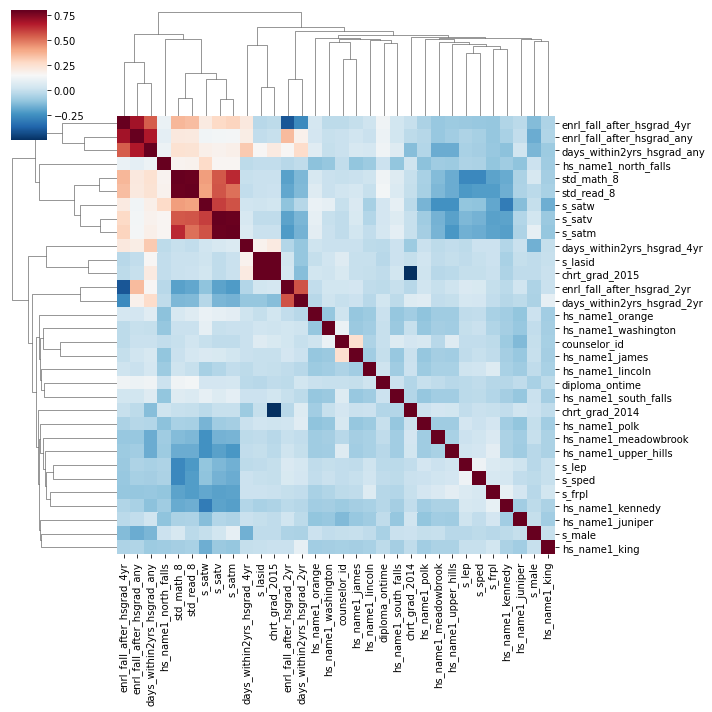

In [35]:
corrmat = scaler_df.corr()
sns.clustermap(corrmat, vmax=.8, square=True, cmap="RdBu_r");
plt.show()

### Some observations from correlation matrix heatmap:
#### Note: Correlation is not causation

1. Years 2014 and 2015 show opposite trend. Since we have only 3 years and two of them contradictory, more years of data should be considered.
2. There is a negative correlation between students enrolling in 2 year and 4 year programs. This suggests the collage type can be used for programs' assessment
3. Strong correlation between grades of different subjects: Those who are better in one subject are good at others too. This bind is a bit weaker betwwen writing and other topics.
4. Students with special need LEPs, and those who receive lunch money have lower grades.

### 2.3. Scree Plot


In [43]:
# Scree plot values: determine how many components sufficiently explain variations.
# Expected Proportion of the kth Largest Piece
# Adobted from https://blogs.sas.com/content/iml/2017/08/02/retain-principal-components.html


vari= eigvals_df=pd.DataFrame(100* pca.explained_variance_ratio_)
vari['1'] = ''
vari['2'] = ''
vari.iloc[0,1] = vari.iloc[0,0]
vari.iloc[0,2] = eig_vals[0].real
for i in np.arange(1, vari.shape[0]):
    vari.iloc[i,1] = vari.iloc[i,0] + vari.iloc[i-1,1]
    vari.iloc[i,2] = eig_vals[i].real
    
vari.columns = ['Exp. Variance (%)', 'Cumulative (%)', 'Eigenvalue']
vari.index = pc(vari.shape[0],0)
vari['Broken Stick Threshold'] = exprop(vari.shape[0])
vari[vari['Exp. Variance (%)'] > vari['Broken Stick Threshold']]


,Exp. Variance (%),Cumulative (%),Eigenvalue,Broken Stick Threshold
PC1,13.944599,13.9446,4.46266,13.316624
PC12,3.393930,61.7296,0.51345,3.250366
PC13,3.338996,65.0686,0.569498,2.972588
PC14,3.302130,68.3708,1.36378,2.716178
PC15,3.284894,71.6557,0.69033,2.478083
PC16,3.147648,74.8033,0.762711,2.255860
PC17,2.976683,77.78,0.800206,2.047527
PC18,2.873862,80.6539,0.873601,1.851449
PC19,2.761003,83.4149,0.883599,1.666264
PC20,2.729761,86.1446,0.919717,1.490825


No handles with labels found to put in legend.


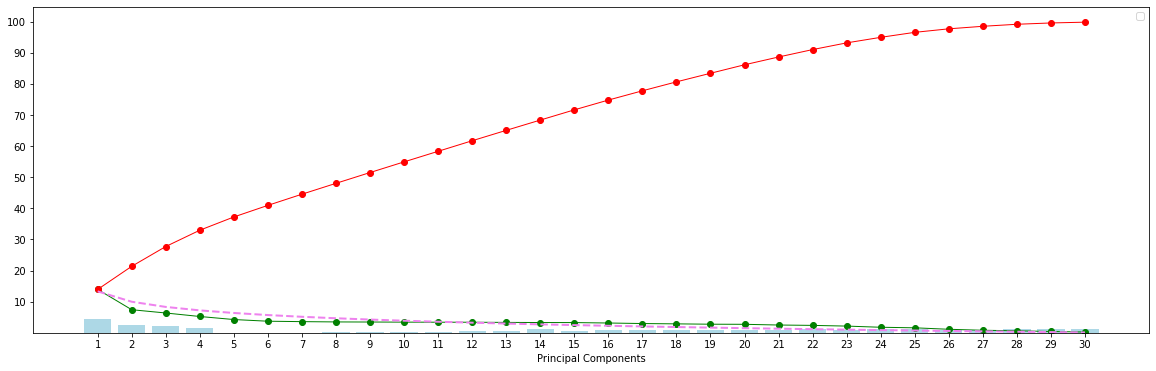

In [41]:
# Scree Plot

# drawing charts and labels

plt.rcParams["figure.figsize"] = [20,6]

exvar = plt.plot(np.arange(1, vari.shape[0]+1),vari['Exp. Variance (%)'], color = 'green', linewidth = 1, marker ='o')
acvar = plt.plot(np.arange(1, vari.shape[0]+1),vari['Cumulative (%)'], color='red', linewidth = 1, marker ='o' )
br_st = plt.plot(np.arange(1, vari.shape[0]+1),vari['Broken Stick Threshold'], color = 'violet', linewidth = 2, linestyle="--")
eival = plt.bar(np.arange(1, vari.shape[0]+1),vari['Eigenvalue'], color = 'lightblue')


plt.xlabel('Principal Components')
plt.xticks(np.arange(1, vari.shape[0]+1))
plt.yticks(np.arange(10, 110, 10))

# first_legend = plt.legend(handles=[exvar,first_legend],loc=1)
# ax = plt.gca().add_artist(first_legend)
plt.legend()
# plt.legend(handles=[eival,first_legend])
plt.show()

### Scree plot observation:

The first component suffice explaining the difference between the individuals. (Showing PC12 and after is probably data noise)

In [48]:
# Based on scree plot result, the dataframe contains one PC for the student

pcaft_df = pd.DataFrame(pca_features)
pcaft_df.columns = pc(pcaft_df.shape[1],0)
pcaft_df.index = students
pcaft_df.drop(list(pcaft_df.columns[np.arange(1,pcaft_df.shape[1])]), axis=1, inplace=True)


In [52]:
# Share of features in PC

pcacom_df = pd.DataFrame(pca.components_.T)
pcacom_df.columns = pc(pcacom_df.shape[1],0)
pcacom_df.index = metrics
pcacom_df.drop(list(pcacom_df.columns[np.arange(1,pcacom_df.shape[1])]), axis=1, inplace=True)


In [64]:
# These factors are the contributing to variation among students the most.

pcaabs_df = pd.DataFrame(abs(pcacom_df['PC1']))
pca_important = pcaabs_df.sort_values(by='PC1', ascending=False)
pca_important.head(10)

,PC1
std_math_8,0.379031
s_satm,0.372670
s_satv,0.367121
std_read_8,0.363506
s_satw,0.323685
enrl_fall_after_hsgrad_4yr,0.288007
days_within2yrs_hsgrad_any,0.231742
enrl_fall_after_hsgrad_any,0.205066
s_frpl,0.142291
hs_name1_north_falls,0.137393


### Principal Component Observations
It appears that the most distinguishing factor to use for scoring are:
1. The standardized grades (Math, SAT tests) 
2. Enrolling for college. The two metric that seem more relevant are:

    2.1. Enrolling for a 4 year degree (ie a good education)
    
    2.2. Enrolling shortly after college (an index for passion for education)
    
**Now that we have selected the criteria to choose schools with, the table will be exported to Excel spreadsheet for better visualization.**


In [96]:
df_school_spreadsheet = df_school[['hs_name1','std_math_8','s_satm','s_satv','std_read_8','s_satw','enrl_fall_after_hsgrad_4yr','days_within2yrs_hsgrad_any']]

In [97]:
df_school_spreadsheet.to_excel('df_school.xlsx')

# 3. Summary

The data and analyses are suggesting that among the SDSM schools, the following ones are good candidates for model school:
- Hope High School
- North Falls High School
- South Falls High School

**Criteria:**
For selecting the model school, the following criteria are the most helpful:
- Students grades on tests
- Look for schools with graduates who enroll shortly after school, or for a higher degree.

**Data quality:**
There were both missing data and duplicated records in the dataset. The missing data was filled in a way that the descriptive measures were not change significantly, and identical records were removed. There was, however, records that belonged to the same ID, but different in at least one field. They were taken into account as possible data retakes, yet subject to controversy.

The impact of counseler was overshadowed by the factors mentioned above. An interesting insight could be investigating the impact within individual schools, not across the district.